# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [15]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 12

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


Splitting train and test data

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2100, 2]) torch.Size([2100, 1])
torch.Size([900, 2]) torch.Size([900, 1])


/tmp/ipython-input-3047193723.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipython-input-3047193723.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipython-input-3047193723.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipython-input-3047193723.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or

In [17]:
def init_weights():
    W1 = torch.randn(2, 16) * 0.1
    b1 = torch.zeros(1, 16)

    W2 = torch.randn(16, 16) * 0.1
    b2 = torch.zeros(1, 16)

    W3 = torch.randn(16, 16) * 0.1
    b3 = torch.zeros(1, 16)

    W4 = torch.randn(16, 1) * 0.1
    b4 = torch.zeros(1, 1)

    # 🔑 MAKE THEM LEAF TENSORS
    for p in [W1, b1, W2, b2, W3, b3, W4, b4]:
        p.requires_grad_()

    return {
        "W1": W1, "b1": b1,
        "W2": W2, "b2": b2,
        "W3": W3, "b3": b3,
        "W4": W4, "b4": b4
    }

params = init_weights()

# Activation Functions
def relu(x):
    return torch.clamp(x, min=0)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


In [18]:
# Forward Pass
def forward(X, p):
    z1 = torch.matmul(X, p["W1"]) + p["b1"]
    a1 = relu(z1)

    z2 = torch.matmul(a1, p["W2"]) + p["b2"]
    a2 = relu(z2)

    z3 = torch.matmul(a2, p["W3"]) + p["b3"]
    a3 = relu(z3)

    z4 = torch.matmul(a3, p["W4"]) + p["b4"]
    y_hat = sigmoid(z4)

    return y_hat

In [19]:
# Binary Cross Entropy Loss
def binary_cross_entropy(y_hat, y):
    eps = 1e-7  # numerical stability
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    return loss.mean()

# Accuracy Function
def accuracy(y_hat, y):
    preds = (y_hat > 0.5).float()
    return (preds == y).float().mean()

In [21]:
lr = 0.05
epochs = 300

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):

    # Train
    y_hat_train = forward(X_train, params)
    loss_train = binary_cross_entropy(y_hat_train, y_train)

    loss_train.backward()

    with torch.no_grad():
     for key in params:
        if params[key].grad is not None:
            params[key] -= lr * params[key].grad
            params[key].grad.zero_()

    # Test
    with torch.no_grad():
        y_hat_test = forward(X_test, params)
        loss_test = binary_cross_entropy(y_hat_test, y_test)
        acc_test = accuracy(y_hat_test, y_test)

    with torch.no_grad():
        acc_train = ((y_hat_train > 0.5).float() == y_train).float().mean()

    # Store
    train_losses.append(loss_train.item())
    val_losses.append(loss_test.item())
    train_accs.append(acc_train.item())
    val_accs.append(acc_test.item())

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch} | "
            f"Train Loss: {loss_train:.4f} | "
            f"Val Loss: {loss_test:.4f} | "
            f"Train Acc: {acc_train:.3f} | "
            f"Val Acc: {acc_test:.3f}"
        )

Epoch 0 | Train Loss: 0.6732 | Val Loss: 0.6690 | Train Acc: 0.610 | Val Acc: 0.627
Epoch 50 | Train Loss: 0.6695 | Val Loss: 0.6638 | Train Acc: 0.610 | Val Acc: 0.627
Epoch 100 | Train Loss: 0.6683 | Val Loss: 0.6618 | Train Acc: 0.610 | Val Acc: 0.627
Epoch 150 | Train Loss: 0.6680 | Val Loss: 0.6611 | Train Acc: 0.610 | Val Acc: 0.627
Epoch 200 | Train Loss: 0.6678 | Val Loss: 0.6607 | Train Acc: 0.610 | Val Acc: 0.627
Epoch 250 | Train Loss: 0.6677 | Val Loss: 0.6605 | Train Acc: 0.610 | Val Acc: 0.627


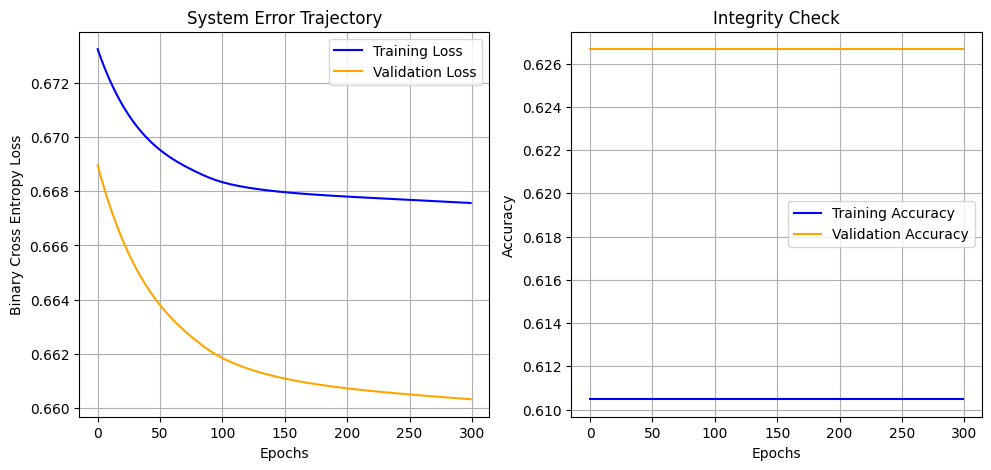

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("System Error Trajectory")
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Training Accuracy", color="blue")
plt.plot(val_accs, label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Integrity Check")
plt.legend()
plt.grid(True)

In [26]:
# Create a dense grid over input space
xx, yy = np.meshgrid(
    np.linspace(-5, 5, 400),
    np.linspace(-5, 5, 400)
)

grid = torch.tensor(
    np.c_[xx.ravel(), yy.ravel()],
    dtype=torch.float32
)

# Forward pass on grid
with torch.no_grad():
    probs = forward(grid, params)
    probs = probs.reshape(xx.shape)

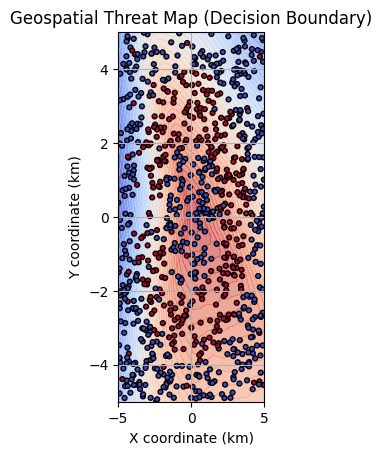

In [28]:
plt.subplot(1, 3, 3)

# Probability heatmap
plt.contourf(
    xx, yy, probs,
    levels=50,
    cmap="coolwarm",
    alpha=0.6
)

# Decision boundary (p = 0.5)
plt.contour(
    xx, yy, probs,
    levels=[0.5],
    colors="black",
    linewidths=2
)

# Validation data points
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test.squeeze(),
    cmap="coolwarm",
    edgecolors="k",
    s=12
)

plt.xlabel("X coordinate (km)")
plt.ylabel("Y coordinate (km)")
plt.title("Geospatial Threat Map (Decision Boundary)")
plt.grid(True)
plt.show()